# Intelligent systems
## Lab4
##  Ahmad Ghalawinji

## Regularization: application with medical microbiology diagnosis

We want to predict the IBD (Inflammatory Bowel Disease) clinical status of patients **given the abundance of microbial species** living in their gut.

Each patient is assigned to a clinical status, and the abundances of known species in their gut are reported in a matrix of size `patient x species`.

We focus here on the seminal metagenomic study by Nielsen H.B. et al, published in 2014.



In [66]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

# Viz
import matplotlib.pyplot as plt

In [67]:
# Load the data
ab_data_pd = pd.read_csv("gut_abundances.tsv", sep="\t", header = 0)
descriptor_names = ab_data_pd.columns
ab_data = ab_data_pd.to_numpy()
status_txt =  pd.read_csv("ibd_status.lst", sep="\t", header = None).to_numpy()
ab_data_pd

,k__Bacteria,k__Archaea,k__Viruses,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Actinobacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Verrucomicrobia,k__Viruses|p__Viruses_noname,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio|s__Thioalkalivibrio_unclassified,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia|s__Labrenzia_unclassified,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid|t__PRJNA186953
MH0001,99.85542,0.12024,0.02435,75.76233,22.45185,0.79821,0.77138,0.12024,0.04902,0.02435,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0002,99.84094,0.00000,0.15906,29.66601,63.00964,0.80546,1.31857,0.00000,5.02320,0.15906,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0003,99.99769,0.00000,0.00231,28.89089,68.87499,1.10182,1.11216,0.00000,0.00000,0.00231,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0004,99.54958,0.44427,0.00615,36.82369,59.90264,0.96707,1.79713,0.44427,0.00000,0.00615,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0005,99.85338,0.02338,0.12324,53.45066,44.00230,0.66402,1.34265,0.02338,0.33886,0.12324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1_UC61_0,100.00000,0.00000,0.00000,73.60036,23.13241,1.97125,1.29598,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC62_0,99.43677,0.53534,0.02789,59.81443,31.16507,1.25950,7.12218,0.53534,0.07560,0.02789,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC7_0,99.97056,0.00000,0.02944,61.47615,31.97288,3.65580,1.59657,0.00000,1.25953,0.02944,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC8_0,96.71485,3.21396,0.01313,26.64142,56.61496,0.68027,7.95935,3.21396,4.79898,0.01313,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Take a look at the data: number of samples ($n$), number of descriptors ($p$), names of descriptors (in ```descriptor_names```), etc.

In [68]:
n,p =ab_data_pd.shape #TO COMPLETE (1 expression)
print("Data shape:",n,p)

Data shape: 396 1939


We now transform the target variable to a binary (0 ==  control, 1 == IBD) variable ```status```:

In [69]:
status = np.ravel([int(s == "IBD") for s in status_txt])

What is the name of the most correlated species (we denote by S) to the clinical status? Use the ```np.corrcoef``` function to compute the correlation between the data and the status.
You can compute the correlation between the data and the status using ```corr_vector = np.corrcoef(ab_data.transpose(),status))[:-1,p]```, which gives the correlation for each species.

In [70]:
corr_vector = np.corrcoef(ab_data.transpose(),status)[:-1,p]
most_correlated_species = descriptor_names[corr_vector.argmax()]
print("Max correlation is ",max(corr_vector))
print("Array index :",corr_vector.argmax())
print("The names of the most correlated species in the data are: " ,most_correlated_species)

Max correlation is  0.40722498985588496
Array index : 6
The names of the most correlated species in the data are:  k__Bacteria|p__Actinobacteria


## Answer1: 
k__Bacteria|p__Actinobacteria are the most correlated species.

Create a (naïve) predictor that takes as input the abundance of S and output the clinical status of the patient. Either compute the prediction accuracy or its AUC ROC for every threshold, this will be our baseline predictor to improve on.

(198, 1939)
(396, 1939)
6


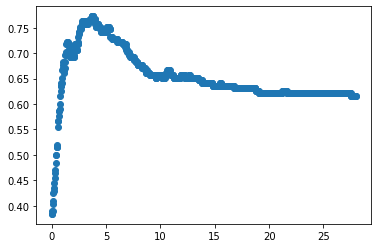

AUC ROC on test set: 0.679563492063492


In [71]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)
print(x_train.shape)
print(ab_data.shape)

# We remove species not abundant in the train set
col_to_rm = np.where(np.sum(x_train,axis=0) == 0)
x_train = np.delete(x_train,col_to_rm,axis=1)
x_test =  np.delete(x_test,col_to_rm,axis=1)
n,p = x_train.shape

# Index of the best correlated species to patient's status
best_cor_sp =corr_vector.argmax() #TO COMPLETE (1 expression)
print(best_cor_sp)

# Compute accuracy 
accuracy = list()
ths = np.linspace(0,int(np.max(x_train[:,best_cor_sp]))+1,1000) # threshold list
for t in ths:
    predictions = (x_train[:,best_cor_sp]>t)
    accuracy += [sum( predictions == y_train)/n]#TO COMPLETE (1 expression)
    
# Plot the decision threshold vs. performance of the predictor
plt.scatter(ths,accuracy)
plt.show()

# "Real" accuracy on test set
# Decision threshold corresponding to the best accuracy.
best_ths =ths[np.argmax(accuracy)]#TO COMPLETE (1 expression)

# Report the accuracy on the test set
prediction = (x_test[:,best_cor_sp]>best_ths)
roc = roc_auc_score(y_test==1,prediction)
print("AUC ROC on test set:",roc)

## Comments:
### The full steps are as follows:
1. Split the data into 50% for both training and testing.
2. Omit the species which are not abundant in the training set.
3. Calculate the correlation between the data and the status in the training set.
4. Get the best-correlated species
5. Plotting the decision threshold compared to the prediction curve.
6. Calculate the accuracy of the training model.


Now we hope that we can do better when using more than 1 descriptor.

We will first use a standard [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html ) function of Sklearn to evaluate your predictor in a cross-validation way.

Take a look at what metrics you can find in the attributes of the cross-validation object `cv` and print the average accuracy.

Do you gain in terms of accuracy compared to a single predictor? Check if you are overfitting the data.

In [72]:
logreg = linear_model.LogisticRegression(solver="liblinear")
cv =cross_validate(logreg,ab_data,y=status,cv=5) #TO COMPLETE (1 expression)
print(cv["test_score"])
test_score =np.mean(cv["test_score"])#TO COMPLETE (1 expression)
print("Average Cross-Validation accuracy on test:",test_score)

# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True)

# Print example accuracy on 1 fold
logreg.fit(x_train,y_train)
logistic_regression_prediction= logreg.predict(x_test)
roc = roc_auc_score(y_test,logistic_regression_prediction)
print("AUC ROC on test set:",roc)

[0.7375     0.84810127 0.79746835 0.78481013 0.59493671]
Average Cross-Validation accuracy on test: 0.7525632911392404
AUC ROC on test set: 0.7744539411206078


## Answer2:
The accuracy of the previous model is around 0.68
The accuracy of the logistic regression model is around 0.77
We have a better accuracy value with logistic regression.
We don't have overfitting in this model for the following reasons:

1. The accuracy is around 0.77, while in the overfitting model it must be around 1.
2. We split the data by half, the data which used for training is different from the data which used for testing.   

Check the `coef_` attribute of your model. How many species are you using for taking the decision?

In [76]:
used_descriptors = logreg.coef_ #TO COMPLETE (1 expression)
print("The model uses ",used_descriptors,"descriptors\n")
print("Number of species used for decision making is",np.count_nonzero(used_descriptors[0]),"descriptors")

The model uses  [[ 4.10256285e-03  1.94083916e-02  9.20858633e-02 ... -1.21117037e-07
  -1.07375526e-07 -2.29802800e-06]] descriptors

Number of species used for decision making is 1661 descriptors


## Answer3:
Obtaining the array of used descriptors using logreg.coef_ we obtained an array of descriptors used. The number of used descriptors is 1661.


Considering that only few bacterial species may be responsible for IBD, choose a relevant regularization (see the available penalties for logistic regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



In [87]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

# Create a regularized model
logreg_regul =linear_model.LogisticRegression(penalty = "l1",solver="liblinear")#TO COMPLETE (1 expression)
logreg_regul.fit(x_train,y_train)
pred = logreg_regul.predict(x_test)

# Report accuracy on test set
#TO COMPLETE
roc = roc_auc_score(y_test,pred)#TO COMPLETE (1 expression)
print("AUC ROC on test set:",roc)

AUC ROC on test set: 0.8171553758004718


Have you increased the accuracy? Looking at `logreg_regul.coef_`, how many descriptors are you using after regularization?
All things considered, is it a better model?

In [80]:
used_descriptors =logreg_regul.coef_#TO COMPLETE (1 expression)
print("We use ",used_descriptors,"descriptors")
print("Number of species used for decision making is",np.count_nonzero(used_descriptors[0]),"descriptors")

We use  [[0.01668907 0.00629109 0.         ... 0.         0.         0.        ]] descriptors
Number of species used for decision making is 122 descriptors


Remember that equivalent accuracy, but with fewer descriptors => more robust and explainable => better model !

Find the optimal regularization strength, by comparing performances on test set and train set. If you have more time, best is to do it by plotting the mean performance in cross-validation, with confidence enveloppe (+/- std deviation) over the folds.


## Answer4:
The approximate accuracy value and used descriptors for both model as follow:
1. penalty = "l2", Number of species used for decision making is 1682 descriptors --> accuracy is 0.76
2. penalty = "l1", Number of species used for decision making is 122 descriptors   --> accuracy is 0.80
 
By training and testing multiple times, much of the time the accuracy in the model with penalty = "l1" is better with regard to the reduced number of descriptors used to take the decision.
The purpose of l1 is to shrink the less important feature’s coeﬀicient to zero.


[0.6314102564102564, 0.6314102564102564, 0.6311538461538462, 0.742948717948718, 0.7578205128205129, 0.8032051282051281, 0.7882051282051282, 0.7832051282051282, 0.7682051282051282, 0.7582051282051282]
1


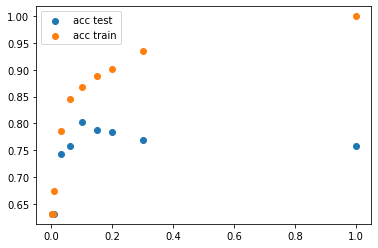

In [91]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

acc_test = list()
acc_train = list()

reg_strengths = [0.001,0.005,0.01,0.03,0.06,0.1,0.15,0.2,0.3,1]
for c in reg_strengths:
    logreg = linear_model.LogisticRegression(penalty = "l1",solver="liblinear",C=c).fit(x_train,y_train)#TO COMPLETE (1 expression)
    cv =cross_validate(logreg,x_test,y=y_test,cv=5,return_train_score = True) #TO COMPLETE (1 expression)
    acc_test += [np.mean(cv["test_score"])]#TO COMPLETE (1 expression)
    acc_train +=[np.mean(cv["train_score"])]#TO COMPLETE (1 expression)
    
print(acc_test)

#print(c)
plt.clf()
plt.scatter(reg_strengths,acc_test, label='acc test')
plt.scatter(reg_strengths,acc_train, label='acc train')
plt.legend()
plt.show()

## comments:
For finding the optimal regularization:
1. implement and train linear logistic regression model with penalty = "l1",solver="liblinear".
2. cross-validate the testing data and calculate the accuracy of the model.
3. calculate the training score.
4. extract the highest value in the accuracy test after plotting the curve between the test accuracy and the training accuracy.


Train a classifier on the full dataset with the optimial regularization strength, and interpret the coefficients. You can check in particular if it is consistent with [this paper](https://pubmed.ncbi.nlm.nih.gov/27999802/) and [this one](https://pubmed.ncbi.nlm.nih.gov/20648002/).

In [92]:
# c is the optimal penalty given the previous graph (hard-code this number)
c =  0.1 #TO COMPLETE (1 expression)

logreg = linear_model.LogisticRegression(penalty = "l1",solver="liblinear",C=c)#TO COMPLETE (1 expression)
logreg.fit(ab_data,status)
# positive association IBD, you can make use of numpy argsort function
order =np.argsort(logreg.coef_)#TO COMPLETE (1 expression)
order = order.tolist()
print("Positive association with IBD\n\n",np.array(descriptor_names)[order[0][0:3]])
print("\n")

# negative association with IBD
order =np.flip(np.argsort(logreg.coef_)).tolist()#TO COMPLETE (1 expression)
print("Negative association with IBD\n\n",np.array(descriptor_names)[order[0][0:3]])


Positive association with IBD

 ['k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_hominis|t__GCF_000225345'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques']


Negative association with IBD

 ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_2_1_58FAA'
 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_unclassified']


## Comments:
After choosing the optimal regularization value:
1. implement and train (on full dataset) linear logistic regression model with penalty = "l1",solver="liblinear"
2. order the coefficient attributes and extract the three first & last descriptors for both Positive associations with IBD and Negative association with IBD.


## Optional: other classifiers

Use other models for supervised classification (decision trees, SVM, neural nets, etc.) with the IBD data. Evaluate properly the performances, and pay attention to regularization!

